# Laboratorio 7: Selección de Atributos

Integrantes: Nahuel Won y Tomás Ubilla sección 3

# Instrucciones


1. Trabajen en equipos de dos personas.

2. Modifique este archivo `.ipynb` agregando sus respuestas donde corresponda.

3. El formato de entrega para esta actividad es un archivo html, **no se revisarán entregas en otro formato**. Genere un archivo HTML y súbalo a U-Cursos. Basta con que uno de los integrantes haga la entrega. Si ambos hacen una entrega en U-Cursos, se revisará cualquiera de éstas.

# Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

In [ ]:
X.shape

(1797,)

In [3]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180]))

# Análisis Exploratorio

**P0** - Para cada parte de esta sección, responda adicionalmente las siguientes preguntas:
1. ¿Qué puede decir de los datos a partir de estos reusultados?
2. ¿Considera que hay que remover alguna columna?

Si la respuesta de la segunda pregunta es afirmativa, elimine esas columnas. Guarde cada modificación que haga sobre los datos en una nueva variable `X2` y mantenga `X` sin modificar.

**P1** - Determine la proporción de los datos que es igual a $0$ y si existen columnas que sólo contienen este valor.

In [10]:
zeros = np.sum(X==0) / X.size   
print(f"proporcion de datos que es igual a 0: {zeros}")

z = np.all(X==0, axis=0)
column_zero = np.where(z)[0]
print(f"columna solo 0: {column_zero}")

proporcion de datos que es igual a 0: 0.4892877017250974
columna solo 0: [ 0 32 39]


1. La proporcion de elementos en la matriz X (de imagenes) que contiene 0s en alguna parte de cada fila es aproximadamente la mitad (pixeles vacios).
2. Si ya que hay informacion inutil en esas columnas. no aportan informacion al esquema.

In [15]:
X2 = np.delete(X, column_zero, axis=1)
X2.shape

(1797, 61)

**P2** - Visualize la matriz de correlación para `X2`. Dada la cantidad de columnas, puede ser útil visualizar también la matriz son subconjuntos más pequeños para un análisis más preciso.

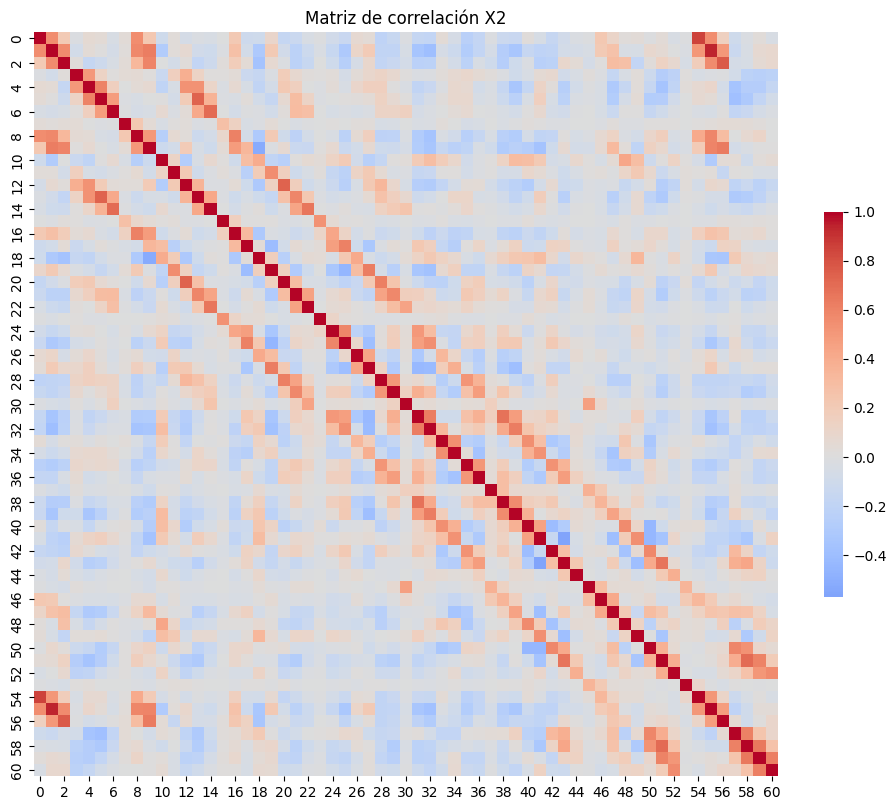

In [16]:
X2_df = pd.DataFrame(X2)

plt.figure(figsize=(12, 10))
sns.heatmap(X2_df.corr(), cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.5})
plt.title('Matriz de correlación X2')
plt.show()

1. En la matriz se puede observar patrones entre columnas adyacentes bien definidas. Se observan regiones con alta correlación. En la diagonal siempre se muestran datos altamente correlacionados lo cual es esperable.
2. No es necesario remover columnas, ya que remover columnas solo por correlaciones puede llevar a pérdida de información que es útil para el modelo.

In [17]:
X2 = ...

**P3** - Calcule la varianza de los datos.

In [18]:
X2_df.var()

0      0.822997
1     22.608374
2     18.052657
3     18.381696
4     32.108290
        ...    
56    19.137948
57    24.343836
58    34.817348
59    16.732582
60     3.460053
Length: 61, dtype: float64

1. Muchas columnas tienen varianza positiva. 
2. Si puede ser necesario remover columnas de varianza baja que no aportan mucha info. 

In [20]:
from sklearn.feature_selection import VarianceThreshold

threshold = VarianceThreshold(threshold=0.01)

X2 = threshold.fit_transform(X2_df)
X2.shape

(1797, 56)

# Selección de Atributos

In [21]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

**P4** - Selecciones las 30 mejores columnas según el criterio de información mutua.

In [29]:
selector = SelectKBest(mutual_info_classif, k=30)

X3_train = selector.fit_transform(X_train, y_train)
X3_test = selector.transform(X_test)
selected_columns = selector.get_support(indices=True)
print(f"columnas seleccionadas: {selected_columns}")


columnas seleccionadas: [ 2  5 10 13 18 19 20 21 25 26 27 28 29 30 33 34 35 36 37 38 42 43 44 46
 51 53 54 58 60 61]


1. Se seleccionaron 30 columnas que fueron consideradas con mejores metricas con mejor informacion mutua.
2. Podria ser completamente util eliminar algunas columnas si podemos verificar que la diferencia entre usar 30 o las 61 columnas es de eficiencia ligeramente diferente pero alta, ya que el poder predictivo se centraria en las k-columnas que determinemos como utiles. 

**P5** - Seleccione las columnas más útiles según los resultados de un árbol de clasificación. Seleccione un máximo de 30.

In [28]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=0)
selec2 = SelectFromModel(estimator=dtc, max_features=30)
selec2.fit(X_train, y_train)

X4_train = selec2.transform(X_train)
X4_test = selec2.transform(X_test)
selected_columns2 = selec2.get_support(indices=True)
print(f"columnas seleccionadas: {selected_columns2}")

columnas seleccionadas: [ 5 20 21 26 27 28 33 34 36 37 38 42 43 44 54 60]


1. Se seleccionaron 16 columnas ya que el parametro de 'max_features' solo considera como maximo tomar 30 columas que vea como mas relevantes.
2. Como se comento anteriormente si las columnas las considera como mas importantes es buena idea dejar solo aquellas que correspondan a dar mayor eficiencia y esta se consigue con datos que centren la mayoria de informacion como en este caso deberiamos dejar estas 16.

# Clasificación

**P6** - Entrene y evalue un clasificador SVC para el dataset sin reducir y cada una de las reducciones hechas en las preguntas anteriores. Para cada caso mida el tiempo de entrenamiento y grafique la matriz de confusión, luego compare y comente los resultados.

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import timeit

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, stratify=y, random_state=0)

def plot_confusion_matrix(true_label, pred_label):
    mat = confusion_matrix(true_label, pred_label)

    fig, ax = plt.subplots()

    ax = sns.heatmap(mat, annot=True, cmap='Reds')
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    plt.show()

tiempo de entrenamiento: 0.03800890001002699


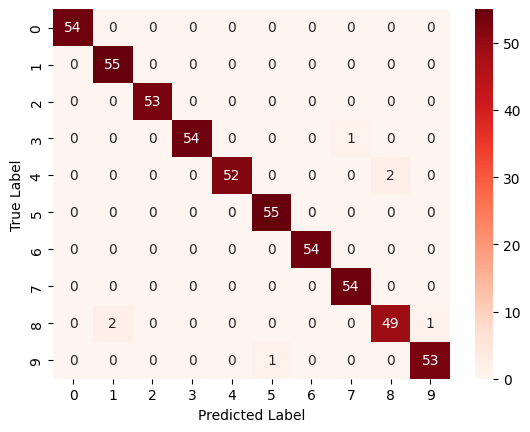

In [31]:
clf = SVC()
s = timeit.default_timer()
clf.fit(X_train, y_train)
e = timeit.default_timer()
print(f"tiempo de entrenamiento: {e - s}")

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

tiempo de entrenamiento: 0.04050150001421571


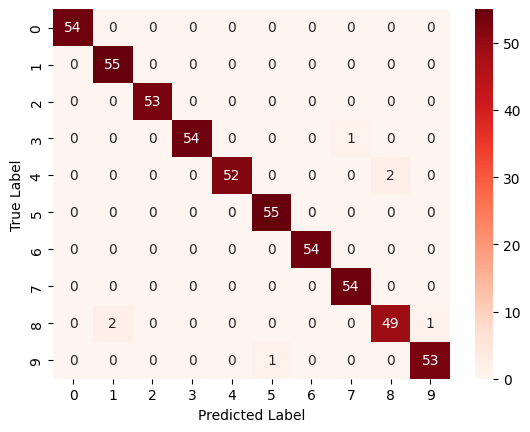

In [32]:
clf2 = SVC()
s = timeit.default_timer()
clf2.fit(X2_train, y_train)
e = timeit.default_timer()
print(f"tiempo de entrenamiento: {e - s}")

y_pred2 = clf2.predict(X2_test)
plot_confusion_matrix(y_test, y_pred2)

tiempo de entrenamiento: 0.03549960002419539


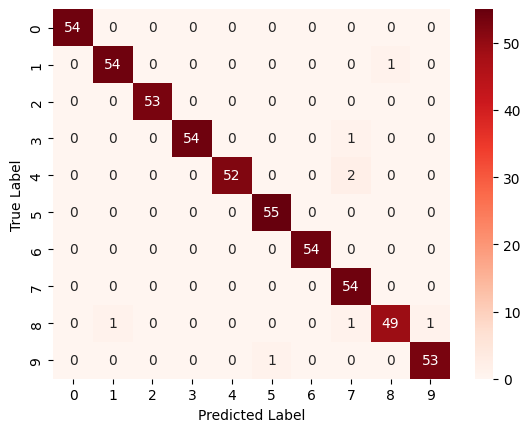

In [33]:
clf3 = SVC()
s = timeit.default_timer()
clf3.fit(X3_train, y_train)
e = timeit.default_timer()
print(f"tiempo de entrenamiento: {e - s}")

y_pred3 = clf3.predict(X3_test)
plot_confusion_matrix(y_test, y_pred3)

tiempo de entrenamiento: 0.033096300001489


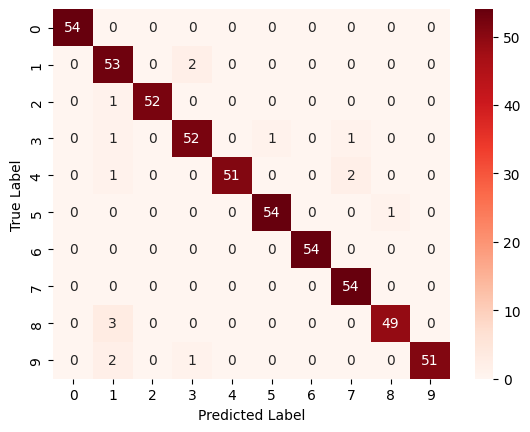

In [34]:
clf4 = SVC()
s = timeit.default_timer()
clf4.fit(X4_train, y_train)
e = timeit.default_timer()
print(f"tiempo de entrenamiento: {e - s}")

y_pred4 = clf4.predict(X4_test)
plot_confusion_matrix(y_test, y_pred4)

Eliminar las columnas menos importantes y constantes mejora ligeramente el tiempo de entrenamiento, mientras que reducir las dimensiones mejora significativamente el tiempo. Se puede observar que X4 es la mejor opción ya que es el que tiene el menor tiempo de entrenamiento.